**Python pre-requisites**


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Import libraries/frameworks**


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

**Setting batch size**

In [0]:
bs = 16

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



**Loading the images and creating the data pipeline**

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_77.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_68.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_107.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_165.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_59.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
                                   size=224, bs=bs).normalize(imagenet_stats)

**Display a sample of the loaded data**

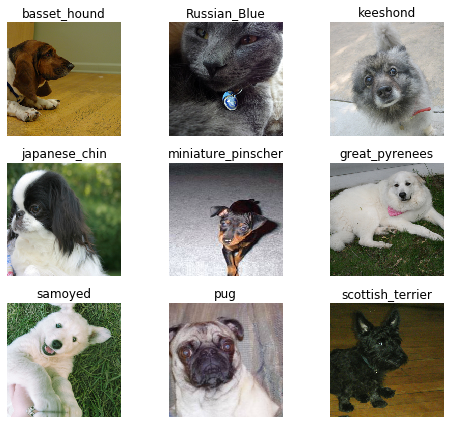

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

**Building and loading the models**

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.8MB/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.925195,0.361691,0.115020,01:52
1,0.729277,0.308536,0.085250,01:51
2,0.489554,0.260101,0.073748,01:52
3,0.379427,0.220199,0.071719,01:52


**Save the learnt model**

In [0]:
learn.save('stage-1')

**Evaluating the model**

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [0]:
len(data.valid_ds)==len(losses)==len(idxs)

True

**Checking the top losses**

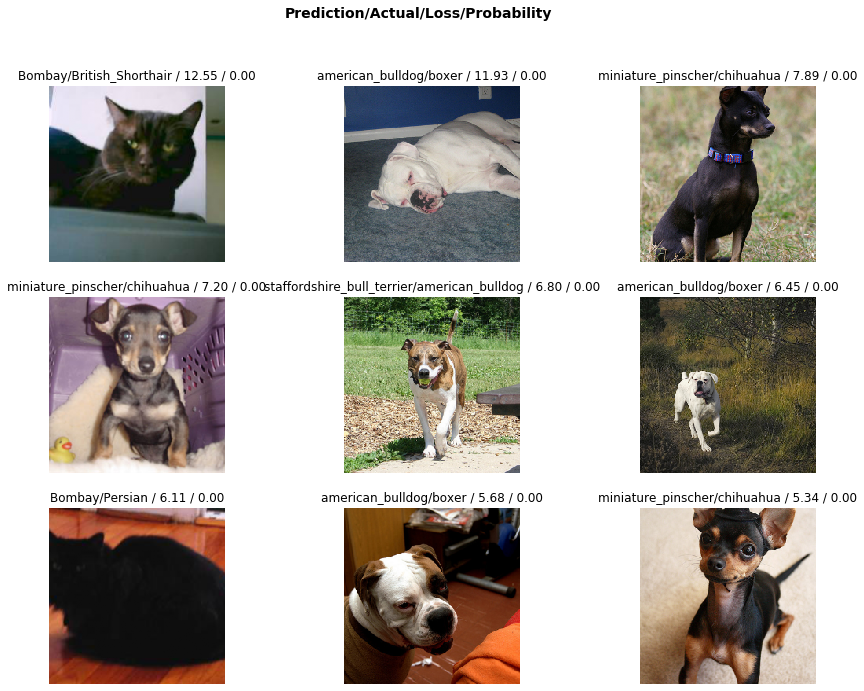

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

**Confusion matrix**

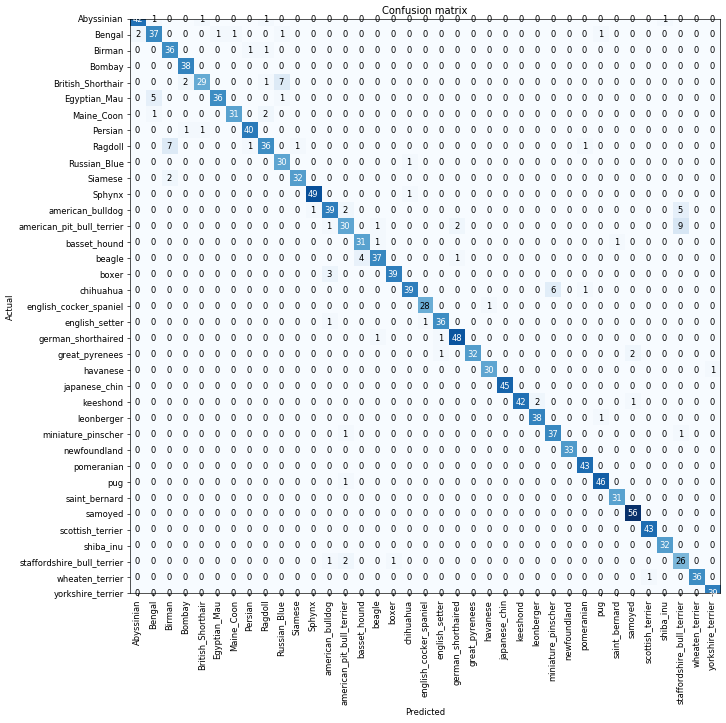

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('British_Shorthair', 'Russian_Blue', 7),
 ('Ragdoll', 'Birman', 7),
 ('chihuahua', 'miniature_pinscher', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('beagle', 'basset_hound', 4),
 ('boxer', 'american_bulldog', 3),
 ('Bengal', 'Abyssinian', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'german_shorthaired', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('keeshond', 'leonberger', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

**Unfreezing, fine-tuning and learning rates**

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.002604,0.441370,0.128552,01:56


In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


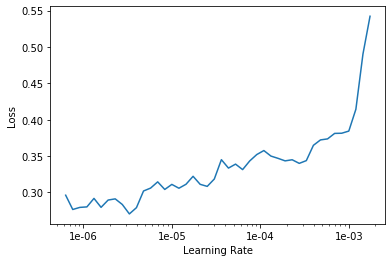

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

**Pick the best learning rate**

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.345931,0.227400,0.071042,01:58
1,0.270026,0.210697,0.060217,01:57
